In [1]:
import pyspark.sql.functions as sqlFunctions
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[4]').appName('test').config('spark.executor.instances', 2).config('spark.executor.memory', '5g').config('spark.executor.cores', 2).getOrCreate()

### Introduction

A well-known online e-commerce marketplace is operating in the Middle East market, selling a multitude of products belonging to several different brands. </br> 
Each of these brands provide a snapshot of all active products readily available in their inventory as data files of different formats (CSV, XML, JSON etc.). </br>
In addition, the list of orders/transactions performed on the marketplace platform is obtained as a JSON file. </br>

### Data Sources

| Name | Format | Description |
|------------|-------------|-------------|
|Brand_Product_Data.csv | CSV | The Product's master file |
|OrdersData.json | JSON | The ordered Product's history |
|Customer_Data.csv | CSV | The Customer's master file |

#### Source Definition

##### Brand_Product_Data

| Name | Data Type | Description |
|------------|-------------|-------------|
|productid | String | The Product's unique ID |
|productname | String | The Product's name |
|onlineflag | Boolean | Flag indicating if the product is currently online |
|onlinefrom | String | The Product's publication date |
|availableflag | Boolean | Flag indicating if the product is available |
|brand | String | The Product's Brand |
|color | String | The Product's Color |
|Category | String | The Product's Category |
|SeasonYear | String | The Product's target Season or Year |

##### Customer_Data

| Name | Data Type | Is Sensitive | Description |
|------------|-------------|-------------|-------------|
|CustomerID | String | No |The Customer's unique ID |
|Email | String | Yes |The Customer's email |
|FirstName | Boolean | No | The Customer's first name |
|LastName | String | Yes | The Customer's last name |
|Phone | Boolean | Yes | Flag indicating if the product is available |

##### OrdersData

| Name | Data Type |  Description |
|------------|-------------|-------------|
|OrderID | String | The Order's unique ID |
|Amount | String | The Ordered Amount |
|CustomerID | Boolean | The associated Customer's Key |
|ProductID | String | The associated Product's Key |
|Payment Type | String | The associated payment's type |
|Payment Gateway | String | The associated payment's gateway type |
|OrderTimestamp | Datetime (YYYY-MM-DD HH-MM-SS) | Flag indicating if the product is available |



### Section 1: Data Modeling / Warehousing
<b> Note </b> :  Feel free to add any documentation, tables, comments which support your analysis or explain your line of thought. The clearer the project, the easier it is for us to understand your decisions.</br>

The internal customers require the development of a centralized source of information which can provide a single source of truth for all business streams. </br>

The Data Engineering department decided to develop a data model (Kimball) which comprises all the requirements made by the internal customers:
* Products and Customers should maintain a historical accuracy/log of changes
* An order can only be made by registered customers and an e-mail can only exist for one account
* An order is represented by a order date, product and amount (in euros) and can be delivered to only one address
* A Customer can have multiple delivery addresses
* A delivery address is composed of: street, house number, postcode and city.
* Naming Conventions: all object names (dimensions, facts, attributes, metrics, etc) should be lower snake cased
* The internal clients want to be able to respond to questions such as:
  * Who are the top 3 most loyal customers per brand (who spends the most amount)?
  * Which are the top 3 sold products?
  * What is the average time between purchases per Brand?
  * How many products have missing Color or Category?
  * What is the average order value per payment type and gateway?


Additional notes from the business:
* The relationship between a Product and a Brand is unique, non-changing
* The Payment Type and Payment Gateway are both low-cardinality cases in a tighly coupled relation

#### Question 1.1

Design a Kimball (Star-Schema) model which responds to the business' needs.

Remember to designate how to tackle historical/log records, foreign keys and other constraints you feel are needed.

You are free to document as you see fit: using external chart tools, via SQL code, markdown tables, etc. As long as its clear, any methodology works.

#### Question 1.2

Create a snippet of SQL code used to answer the client's questions using your proposed Data Model.

#### Question 1.3

The orders fact can grow exponentially throuhout time. How could you tackle such growth in a performant manner whilst still serving users?

#### (Optional) Question 1.4

How would you tackle data quality problems and solving them at the enterprise-level?

## Question 1.1


First of all for design Star-Schema which responds to business needs, we have to lookup on source data provided and extract business facts and demensions. In this case orders will be Facts, customers, delivery_addresses, payments, products are Demensions.

### ER Diagram:

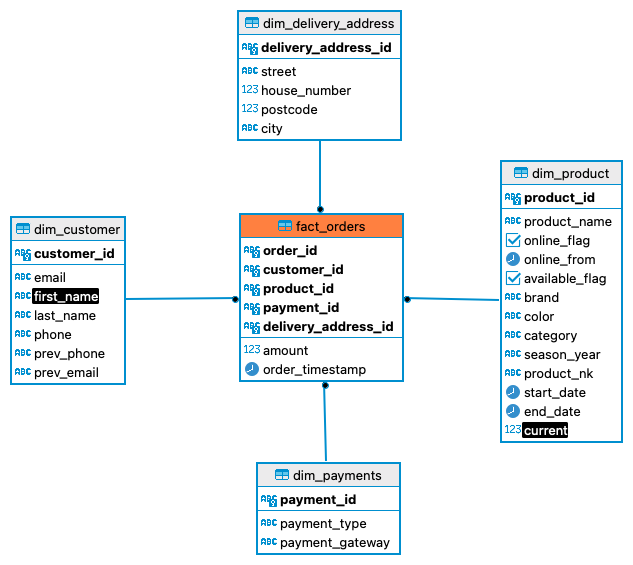


### Bus-Matrix:

| Fact Table / OLAP Cube  | Granularity  | Facts  | payments | product | customer | delivery_address |
|---|---|---|---|---|---|---|
| <b> Orders </b>  |   |   |   |   |   |   |
| Order Transactions  | 1 row for every transaction item (multiple quantities)  | Ordered Amount  | X  | X | X  | X  |

### fact_orders:

| Field Name  | Field Type  | Description |
|---|---|---|
| order_id  | varchar(20) | The order's Degenerate Dimension |
| customer_id  | varchar(20) | The customer's Foreign Key |
| product_id  | varchar(20) | The product's Foreign Key |
| payment_id  | varchar(20) | The payments Foreign Key |
| delivery_address_id | varchar(20) | The address Foreign Key |
| amount  | numeric(100,2) | The Ordered Amount |
| order_timestamp | timestamp | Order timestamp |

customer_id, product_id, payment_id, delivery_address_id foreign keys which reffers to demension tables. Primary key was created from composite of foreign keys + order_id which is Degenarate Demension of this Fact. Its helps to keep orders only for registered customers (which have records in dim_customer table).

Business says that The Payment Type and Payment Gateway are both low-cardinality cases in a tighly coupled relation. This seems to be a classic example of a junk dimension that combines together a number of miscellaneous, low-cardinality ﬂags and indicators. Putting every low cardinality attribute in a separate, dedicated dimension could result in an overly complex model with excessive number of dimension tables (centipede fact tables). Storing the attributes directly in the fact table is allowed but reserved only for degenerate dimensions, i.e. values like order or invoice numbers, retail point-of-sale transaction numbers - high-cardinality values that don't have any additional attributes describing them. Instead of putting each of them in a separate dimension table, the easiest way to create the dimension is to cross-join the source system lookup tables. This creates all possible combinations of attributes, even if they might never exist in the real world. In the second case, when the cross-join would yield too many rows, you can create the combined dimension based on actual combinations found in the transaction fact records. So finally columnt payment_id is reffers to demension table dim_payments which consist all these combinations.

delivery_address_id reffers to dim_delivery_address table which helps to maintain a customer have multiple delivery addresses. Also this table might be used in another Fact tables. If we had Customer and address in the same dimension, we would either have to have columns for each type of address or have a row for each combination of address and customer. So if our Customer and Address dimension had 1 row for every combination of customer and address, we would not able to know which address exactly must be useed for delivery, so it would be useless. The link between Customer and his delivery address is held in the Fact table. Another way its to create factless fact table just to link customers and addresses but in this case we was not asking about reporting customer and address information indepedant of any order activity. Summarizing all of the above was decided to use separate demension table for delivery addresses.

Keep order_timestamp in Fact table as degenerate dimensions. Because in this case we just need effective timestamp.


To satisfy "An order is represented by a order date, product and amount (in euros) and can be delivered to only one address" unique constraint was added for order_timestamp, product and amount columns.


### dim_payments:

| Field Name  | Field Type  | Description |
|---|---|---|
| payment_id  | varchar(20) | The payment's unique ID |
| payment_type  | varchar(10) | Payment type |
| payment_gateway  | varchar(10) | Payment gateway |


This table contains all combinations of payment type and payment gateway as was described above. Added composite unique constraint of payment_type and payment_gateway to prevent duplicated data.

### dim_delivery_address:

| Field Name  | Field Type  | Description |
|---|---|---|
| delivery_address_id  | varchar(20) | The address unique ID |
| street  | varchar(20) | Street |
| house_number  | int(8) | House number |
| postcode | int(8) | Zip code |
| city | varchar(20) | City |


Demension table which contain one row per unique address. As requested A delivery address is composed of: street, house number, postcode and city. Added composite unique constraint (street, house_number, postcode, city) to keep unique addresses. In case we have to provide reporting based on geography basis we can to create a seperate geography dimension with Zip Code at it's lowest level. This Zip Code dimension lets us by pass joins an address table to aggregate facts to the Zip code, city, state, county etc.

### dim_customer:

| Name | Data Type |  Description |
|------------|-------------|-------------|
|customer_id | varchar(20) | The Customer's unique ID |
|email | varchar(20) | The Customer's email |
|first_name | varchar(20) | The Customer's first name |
|last_name | varchar(20) |  The Customer's last name |
|phone | varchar(20) |  The Customer's phone |
|prev_phone | varchar(20) | SCD3 field keeping previous phone |
|prev_email | varchar(20) | SCD3 field keeping previous email |

Dimension table which contains data about customers. To maintain a historical accuracy/log of changes additional columns (prev_phone, prev_email) was added. They will be updated by current value when current columns will be updated with new values. Using SCD3 instead of SCD2 (full history log with duplicated rows which was changed) allow as also add contstraint on email and satisfy requirements that an e-mail can only exist for one account.


### dim_product:

| Field Name  | Field Type  | Description |
|---|---|---|
| product_id  | String | The Product's unique hash |
| product_nk  | String | The Product's natural key |
| product_name | String | The Product's name |
| online_flag  | Boolean | "True" if the product is online, "False" otherwise |
| available_flag  | Boolean | "True" if the product is available, "False" otherwise |
| online_from | timestamp | The Product's publication date |
| brand  | varchar(20) | The Product's Brand |
| color  | String | The Product's Color |
| category  | String | The Product's Category |
| season_year  | String | The Product's Season |
|start_date| timestamp | SCD2 field keeping start date of record|
|end_date| timestamp | SCD2 field keeping end date of record|
|current| int | SCD2 field keeping 1 or 0 depends version|


To keep historycal data SCD2 was used.


### DDL:

### -- public.dim_customer definition

-- Drop table

-- DROP TABLE dim_customer;

CREATE TABLE dim_customer (
	customer_id varchar(20) NOT NULL,
	email varchar(20) NOT NULL,
	first_name varchar NOT NULL,
	last_name varchar(20) NOT NULL,
	phone varchar(20) NOT NULL,
	prev_phone varchar(20) NULL,
	prev_email varchar(20) NULL,
	CONSTRAINT dim_customer_pk PRIMARY KEY (customer_id),
	CONSTRAINT dim_customer_un UNIQUE (email)
);


-- public.dim_delivery_address definition

-- Drop table

-- DROP TABLE dim_delivery_address;

CREATE TABLE dim_delivery_address (
	delivery_address_id varchar(20) NOT NULL,
	street varchar(20) NULL,
	house_number int8 NULL,
	postcode int8 NULL,
	city varchar(20) NULL,
	CONSTRAINT dim_delivery_address_pk PRIMARY KEY (delivery_address_id),
	CONSTRAINT dim_delivery_address_un UNIQUE (street, house_number, postcode, city)
);


-- public.dim_payments definition

-- Drop table

-- DROP TABLE dim_payments;

CREATE TABLE dim_payments (
	payment_id varchar(20) NOT NULL,
	payment_type varchar(10) NOT NULL,
	payment_gateway varchar(10) NOT NULL,
	CONSTRAINT dim_payments_pk PRIMARY KEY (payment_id),
	CONSTRAINT dim_payments_un UNIQUE (payment_type, payment_gateway)
);


-- public.dim_product definition

-- Drop table

-- DROP TABLE dim_product;

CREATE TABLE dim_product (
	product_id varchar(20) NOT NULL,
	product_name varchar(20) NOT NULL,
	online_flag bool NOT NULL,
	online_from timestamp NULL,
	available_flag bool NULL,
	brand varchar(20) NULL,
	color varchar(10) NOT NULL,
	category varchar(15) NOT NULL,
	season_year varchar(4) NOT NULL,
	product_nk varchar(20) NOT NULL,
	start_date timestamp NOT NULL,
	end_date timestamp NULL,
	"current" int4 NOT NULL,
	CONSTRAINT dim_product_pk PRIMARY KEY (product_id)
);


-- public.fact_orders definition

-- Drop table

-- DROP TABLE fact_orders;

CREATE TABLE fact_orders (
	order_id varchar(40) NOT NULL,
	amount numeric(100, 2) NULL,
	customer_id varchar(20) NOT NULL,
	product_id varchar(20) NOT NULL,
	payment_id varchar(20) NOT NULL,
	delivery_address_id varchar(20) NOT NULL,
	order_timestamp timestamp NOT NULL,
	CONSTRAINT fact_orders_pk PRIMARY KEY (order_id, customer_id, product_id, payment_id, delivery_address_id),
	CONSTRAINT fact_orders_un UNIQUE (order_timestamp, amount, product_id),
	CONSTRAINT fact_orders_customer_fk FOREIGN KEY (customer_id) REFERENCES dim_customer(customer_id),
	CONSTRAINT fact_orders_delivery_fk FOREIGN KEY (delivery_address_id) REFERENCES dim_delivery_address(delivery_address_id),
	CONSTRAINT fact_orders_fk FOREIGN KEY (payment_id) REFERENCES dim_payments(payment_id),
	CONSTRAINT fact_orders_products_fk FOREIGN KEY (product_id) REFERENCES dim_product(product_id)
);

## Question 1.2

* Who are the top 3 most loyal customers per brand (who spends the most amount)?
* Which are the top 3 sold products?
* What is the average time between purchases per Brand?
* How many products have missing Color or Category?
* What is the average order value per payment type and gateway?

In [ ]:
# Who are the top 3 most loyal customers per brand (who spends the most amount)?

SELECT product_id, brand, sales
FROM (
  SELECT p.product_id, 
         p.brand, 
         o.sales,
         ROW_NUMBER() OVER (PARTITION BY p.brand ORDER BY o.sales DESC) rn
  FROM dim_product as p 
  INNER JOIN (
    SELECT product_id, SUM(amount) as sales
    FROM fact_orders
    GROUP BY product_id
  ) as o ON o.product_id = p.product_id
) as t
WHERE rn <= 3
ORDER BY product_id;

In [ ]:
# Which are the top 3 sold products?

SELECT dp.product_name, count(amount) as sales
FROM fact_orders as fo
JOIN dim_product as dp
    ON dp.product_id = fo.product_id
GROUP BY product_id
ORDER BY count(amount)
LIMIT 3

In [ ]:
# What is the average time between purchases per Brand?

SELECT brand, (MAX(fo.order_timestamp) - MIN(fo.order_timestamp)) / (COUNT(*) - 1)
FROM fact_orders as fo
JOIN dim_product as dp
    ON dp.product_id = fo.product_id
GROUP BY brand
HAVING COUNT(*) > 1

In [ ]:
# How many products have missing Color or Category?

SELECT sum(case when dp.color is null or dp.category is null then 1 else 0 end) as total
FROM dim_product


In [ ]:
# What is the average order value per payment type and gateway?

SELECT dp.payment_type, dp.payment_gateway, avg(fo.amount)
FROM fact_orders as fo
JOIN dim_payments as dp
    ON dp.payment_id = fo.payment_id
GROUP BY dp.payment_type, dp.payment_gatewayz n

## Question 1.3

The orders fact can grow exponentially throuhout time. How could you tackle such growth in a performant manner whilst still serving users?

#### 1. One of the technique segment the fact table (e.g., by mod’ing the date key), and distribute all dimensions across all nodes.  
That way all joins can be done locally. Partitioning can provide manageability and often performance benefits such as:
* Faster, more granular index maintenance.
* Faster data loading and deleting
* Faster queries when restricted to a single partition

#### 2. We can build clustered index on the date key of the fact table.  
This supports efficient queries to populate cubes or retrieve a historical data slice. Build nonclustered indexes for each foreign key. This helps ‘pinpoint queries' to extract rows based on a selective dimension predicate.


## Question 1.4

We can use Azure Data Catalog.

### Data quality metrics:

Data quality metrics are key to assessing and increasing the quality of your data products. At a global and domain level, you need to decide upon your quality metrics. At a minimum, we recommend the following metrics:

| Metrics  | Metrics definitions  |
|---|---|
| Completeness = % total of non-nulls + non-blanks  | Measures data availability, fields in the dataset that aren't empty, and default values that were changed. For example, if a record includes 01/01/1900 as a data of birth, it's highly likely that the field was never populated. |
| Uniqueness = % of non-duplicate values  | Measures distinct values in a given column compared to the number of rows in the table. For example, given four distinct color values (red, blue, yellow, and green) in a table with five rows, that field is 80% (or 4/5) unique. |
| Consistency = % of data having patterns | Measures compliance within a given column to its expected data type or format. For example, an email field containing formatted email addresses, or a name field with numeric values. |
| Validity= % of reference matching | Measures successful data matching to its domain reference set. For example, given a country field (complying with taxonomy values) in a transactional records system, the country value of "US of A" isn't valid. |
| Accuracy= % of unaltered values | Measures successful reproduction of the intended values across multiple systems. For example, if an invoice itemizes a SKU and extended price that differs from the original order, the invoice line item is inaccurate. |
| Linkage = % of well-integrated data | Measures successful association to its companion reference details in another system. For example, if an invoice itemizes an incorrect SKU or product description, the invoice line item isn't linkable. |

### Data profiling:

Data profiling examines data products that are registered, in the data catalog, and collects statistics and information about that data. To provide summary and trend views about the data quality over time, store this data in your metadata repository against the data product.

Data profiles help users answer questions about data products, including:

* Can it be used to solve my business problem?
* Does the data conform to particular standards or patterns?
* What are some of the anomalies of the data source?
* What are possible challenges of integrating this data into my application?
* Users can view the data product profile by using a reporting dashboard within their data marketplace.

You can report on such items as:

* Completeness: Indicates the percentage of data that isn't blank or null
* Uniqueness: Indicates the percentage of data that isn't duplicated
* Consistency: Indicates data where data integrity is maintained


### Data quality recommendations:

To implement data quality, you need to use both human and computational power as follows:

* Use solutions that include algorithms, rules, data profiling and metrics.

* Use domain experts who can step in when there's a requirement to train an algorithm due to a high number of errors passing through the compute layer.

* Validate early. Traditional solutions have extracted, transformed, and loaded data before any data quality has been applied. By this time, the data product is already being consumed and errors surfaced to downstream data products. Instead, as data is ingested from the source, implement data quality checks near the sources and before downstream consumers use the data products. If there's batch ingestion from the data lake, do these checks when you move data from raw to enriched.

* Before data is moved to the enriched layer, its schema and columns are checked against the metadata registered in the data catalog.

* If the data contains errors, the load is stopped, and the data application team notified of the failure.

* If the schema and column checks pass, the data is loaded into the enriched layers with conformed data types.

* Before you move to the enriched layer, a data quality process checks for compliance against the algorithms and rules.

### Data quality solutions:

* Informatica
* Talend
* CluedIn
* Ataccama One.



#### Section 2 - Implement DW

Whereas in the first section you were asked to develop a model representing the business' needs, in the current section we ask you to apply a set of transformations and cleanup in order to implement a specified data warehouse.

<b> Important : </b> The implementation should be performed in Pyspark. If you do not have access to a Python-based Spark cluster there are several free options, to facilitate implementations we recommend the following:
- Sign up for a <b> free </b> Databricks Community Edition account, <a href="https://community.cloud.databricks.com/login.html">here</a>.

Requirements:
* Orders with invalid or negative amount values should be discarded
* An order can only be made by registered customers and an e-mail can only exist for one account
* Sensitive Fields should be masked
* Naming Conventions: all object names (dimensions, facts, attributes, metrics, etc) should be lower snake cased
* The internal clients want to be able to respond to questions such as:
  * Who are the top 3 most loyal customers per brand (who spends the most amount)?
  * Which are the top 3 sold products?
  * What is the average time between purchases per Brand?
  * How many products have missing Color or Category?

Additional notes from the business:
* The relationship between a Product and a Brand is unique, non-changing

<b> Note: </b> To faciliate and to prevent wasting the candidate's time, a helper function used to generate dates is given below.

#### Bus-Matrix


| Fact Table / OLAP Cube  | Granularity  | Facts  | Date | Time | Customer | Product |
|---|---|---|---|---|---|---|
| <b> Orders </b>  |   |   |   |   |   |   |
| Order Transactions  | 1 row for every transaction item (multiple quantities)  | Ordered Amount  | X  | X | X  | X  |

#### Object Definition


##### Dimensions

###### Dim_Date

| Field Name  | Field Type  | Description |
|---|---|---|
| date_id  | String | The Date's unique hash |
| year_number  | Integer | The integer representing the date's year |
| quarter_number  | Integer | The integer representing the date's quarter |
| quarter_name_short  | String | The quarter's short name, e.g. "Q1", "Q2", etc |
| quarter_name_long  | String | The quarter's long name, e.g. "1st Quarter", "2nd Quarter", etc |
| day_of_month  | Integer | The integer representing the date's day of month |
| day_of_week  | Integer | The integer representing the date's day of week |
| is_weekend  | String | "True" if the day is a Saturday or Sunday, "False" otherwise |

###### Dim_Time

| Field Name  | Field Type  | Description |
|---|---|---|
| time_id  | String | The Time's unique hash |
| hour_number  | Integer | The integer representing the time's hour |
| minute_number  | Integer | The integer representing the time's minute |
| second_number  | Integer | The integer representing the time's second |

###### Dim_Customer

| Field Name  | Field Type  | Description |
|---|---|---|
| customer_id  | String | The Customer's unique hash |
| customer_nk  | String | The Customer's natural key |
| first_name  | String | The Customer's first name |
| last_name  | String | The Customer's last name |
| email_address  | String | The Customer's e-mail address |
| phone_address  | String | The Customer's phone number |

###### Dim_Product

| Field Name  | Field Type  | Description |
|---|---|---|
| product_id  | String | The Product's unique hash |
| product_nk  | String | The Product's natural key |
| product_name | String | The Product's name |
| is_online  | String | "True" if the product is online, "False" otherwise |
| is_available  | String | "True" if the product is available, "False" otherwise |
| brand_name  | String | The Product's Brand |
| product_color  | String | The Product's Color |
| product_category  | String | The Product's Category |
| product_season  | String | The Product's Season |

##### Facts

###### Fact_Order

| Field Name  | Field Type  | Description |
|---|---|---|
| order_dd  | String | The Order's Degenerate Dimension |
| date_id  | Integer | The Date's Foreign Key |
| product_id  | Integer | The Product's Foreign Key |
| customer_id  | Integer | The Customer's Foreign Key |
| order_amount  | Float | The Ordered Amount |

##### Helper Functions

In [243]:
def generate_dates(spark, range_list, interval=60, date_column_name ="date_time_ref"):
     """
     Create a Spark DataFrame with a single column named date_column_name and a range of date within a specified interval (start and stop included).
     With hourly data, dates end at 23 of stop day

     :param range_list: array of strings formatted as "2018-01-20" or "2018-01-20 00:00:00"
     :param interval: number of seconds (frequency), output from get_freq()
     :param date_column_name: string with date column name. Date column must be TimestampType

     :returns: df from range
     """
    
     start,stop = range_list
     time_df = spark.createDataFrame([(start, stop)], ("start", "stop"))
     time_df = time_df.select([sqlFunctions.col(c).cast("timestamp") for c in ("start", "stop")])
     time_df = time_df.withColumn("stop", sqlFunctions.date_add("stop",1).cast("timestamp"))
     time_df = time_df.select([sqlFunctions.col(c).cast("long") for c in ("start", "stop")])
      
     start, stop = time_df.first()
    
     return spark.range(start,stop,interval).select(sqlFunctions.col("id").cast("timestamp").alias(date_column_name))
    
date_range = ["2019-08-14 21:10:18","2021-08-12 12:30:14"]
timestamp_column: str = "date_time_ref"
dates = generate_dates(spark,date_range, date_column_name= timestamp_column)

In [237]:
dim_customers = spark.read. \
    format('csv') \
    .option("delimiter", "|") \
    .option("header", True) \
    .load('/home/jovyan/work/Customer_Data.csv')
dim_customers = dim_customers.withColumn('customer_id', sqlFunctions.expr("uuid()"))
dim_customers = dim_customers.select(sqlFunctions.col('customer_id'),
                            sqlFunctions.col('CustomerID').alias('customer_nk').cast('string'),
                            sqlFunctions.col('Email').alias('email').cast('string'),
                            sqlFunctions.col('FirstName').alias('first_name').cast('string'),
                            sqlFunctions.col('LastName').alias('last_name'),
                            sqlFunctions.col('Phone').alias('phone').cast('string'))
dim_customers.show()

+--------------------+-----------+--------------------+----------+---------+---------------+
|         customer_id|customer_nk|               email|first_name|last_name|          phone|
+--------------------+-----------+--------------------+----------+---------+---------------+
|211884c2-1a8e-4ff...| CUST100000|convallis.in@Maur...|    Sandra|  Langley|(031744) 042019|
|980d45b0-9334-422...| CUST100001|neque.Morbi.quis@...|  Channing|    Haney|(0848) 92697918|
|904a8ec5-c64f-42f...| CUST100002|netus.et@ipsumdol...|     Magee|    Jones|(0036) 70651268|
|188dfe10-ebac-476...| CUST100003|Integer@scelerisq...|    Dennis|    Cantu| (093) 10349778|
|a5723044-8322-4f4...| CUST100004|ipsum.Suspendisse...|    Mariko|   Wright| (046) 26402691|
|bdc7930f-7ff5-456...| CUST100005|et@urnaNullamlobo...|    Jescie|    Blake|(033747) 532259|
|3ed81954-8ab6-4fc...| CUST100006|sem.semper@eueuis...|    Nathan|   Vargas|(0407) 22860639|
|f9c8c56a-569e-4c3...| CUST100007|Suspendisse.commo...|     Plato|   A

In [238]:
dim_products = spark.read \
    .format('csv') \
    .option("header", True) \
    .load('/home/jovyan/work/Brand_Product_Data.csv')
dim_products = dim_products.withColumn('product_id', sqlFunctions.expr("uuid()"))
dim_products = dim_products.select(sqlFunctions.col('product_id'),
                                  sqlFunctions.col('productid').alias('product_nk').cast('string'),
                                  sqlFunctions.col('productname').alias('product_name').cast('string'),
                                  sqlFunctions.col('onlineflag').alias('is_online').cast('string'),
                                  sqlFunctions.col('availableflag').alias('is_available').cast('string'),
                                  sqlFunctions.col('brand').alias('brand_name').cast('string'),
                                  sqlFunctions.col('color').alias('product_color').cast('string'),
                                  sqlFunctions.col('Category').alias('product_category').cast('string'),
                                  sqlFunctions.col('SeasonYear').alias('product_season').cast('string'))
dim_products.show()

+--------------------+----------+--------------------+---------+------------+----------+-------------+----------------+--------------+
|          product_id|product_nk|        product_name|is_online|is_available|brand_name|product_color|product_category|product_season|
+--------------------+----------+--------------------+---------+------------+----------+-------------+----------------+--------------+
|08b92e85-d248-4c9...|SA10001001| Moa Jackets - Black|    FALSE|       FALSE|       Moa|        Black|         Jackets|          AW20|
|9443d768-8182-4cd...|SA10001002|  Moa Trousers - Red|     TRUE|        TRUE|       Moa|          Red|        Trousers|          SS20|
|716f417d-6d67-4b1...|SA10001003|  Moa Sandals - Gold|     TRUE|        TRUE|       Moa|         Gold|         Sandals|          SS20|
|1e9f064c-6234-4fe...|SA10001004|   Moa Sandals - Red|     TRUE|        TRUE|       Moa|          Red|         Sandals|          SS20|
|302f9fbe-e46a-4f8...|SA10001005|Moa Sandals - Silver| 

In [246]:
date_range = ["2019-08-14 21:10:18","2021-08-12 12:30:14"]
dates = generate_dates(spark,date_range, date_column_name= timestamp_column)
dim_date = dates.withColumn('date_id', sqlFunctions.expr("uuid()"))
dim_date = dim_date.select(sqlFunctions.col('date_id'),
                       sqlFunctions.year('date_time_ref').alias('year_number').cast('integer'),
                       sqlFunctions.date_format(sqlFunctions.col('date_time_ref'), 'q').alias('quarter_number').cast('integer'),
                       sqlFunctions.concat(sqlFunctions.lit('Q'), sqlFunctions.date_format(sqlFunctions.col('date_time_ref'), 'q')).alias('quarter_name_short').cast('string'),
                       sqlFunctions.concat(sqlFunctions.date_format(sqlFunctions.col('date_time_ref'), 'q'), sqlFunctions.lit(' '), sqlFunctions.lit('Quarter')).alias('quarter_name_long').cast('string'),
                       sqlFunctions.dayofmonth('date_time_ref').alias('day_of_month').cast('integer'),
                       sqlFunctions.dayofweek('date_time_ref').alias('day_of_week').cast('integer'),
                       sqlFunctions.dayofweek('date_time_ref').isin([1,7]).alias('day_of_week').cast('boolean').cast('string'))
dim_date.show()

+--------------------+-----------+--------------+------------------+-----------------+------------+-----------+-----------+
|             date_id|year_number|quarter_number|quarter_name_short|quarter_name_long|day_of_month|day_of_week|day_of_week|
+--------------------+-----------+--------------+------------------+-----------------+------------+-----------+-----------+
|b367c320-a28a-4e7...|       2019|             3|                Q3|        3 Quarter|          14|          4|      false|
|74ef3112-d233-4aa...|       2019|             3|                Q3|        3 Quarter|          14|          4|      false|
|d1fd8f57-0123-40f...|       2019|             3|                Q3|        3 Quarter|          14|          4|      false|
|d313e29f-2d7d-4b4...|       2019|             3|                Q3|        3 Quarter|          14|          4|      false|
|bd1c37de-466e-4c0...|       2019|             3|                Q3|        3 Quarter|          14|          4|      false|
|99feb6e

In [247]:
date_range = ["2019-08-14 21:10:18","2021-08-12 12:30:14"]
dates = generate_dates(spark,date_range, date_column_name= timestamp_column)
dim_time = dates.withColumn('time_id', sqlFunctions.expr("uuid()"))
dim_time = dim_time.select(sqlFunctions.col('time_id'),
                          sqlFunctions.hour('date_time_ref').alias('hour_number').cast('integer'),
                          sqlFunctions.minute('date_time_ref').alias('minute_number').cast('integer'),
                          sqlFunctions.second('date_time_ref').alias('second_number').cast('integer'))
dim_time.show()

+--------------------+-----------+-------------+-------------+
|             time_id|hour_number|minute_number|second_number|
+--------------------+-----------+-------------+-------------+
|15270932-24ac-41c...|         21|           10|           18|
|5e15b0b8-eb83-4c6...|         21|           11|           18|
|41645876-0389-4c3...|         21|           12|           18|
|950576c3-7b9e-495...|         21|           13|           18|
|9d479eee-2601-45f...|         21|           14|           18|
|3ff7c0c9-85d7-48c...|         21|           15|           18|
|250928db-379e-4bb...|         21|           16|           18|
|bc6fe8b0-061c-4d1...|         21|           17|           18|
|7d6ae794-830d-440...|         21|           18|           18|
|6d1def87-38db-43f...|         21|           19|           18|
|faece096-229c-4ac...|         21|           20|           18|
|845e23cb-1170-4b7...|         21|           21|           18|
|c8096533-8749-4d8...|         21|           22|       

In [248]:
fact_order = spark.read \
    .option("multiline", True) \
    .format('json') \
    .load('/home/jovyan/work/OrdersData.json')
  
# collect the headers as a list
headers = fact_order.select(sqlFunctions.explode("cols").alias("headers")).distinct().collect()
headers = [r.headers for r in headers]
  
# explode data arrays so that it has the same dimensions as the header array
fact_order = fact_order.select(sqlFunctions.explode("data").alias("data"), "cols")
# zip data and headers together to form a map
fact_order = fact_order.select(sqlFunctions.arrays_zip("cols", "data").alias("map"))
fact_order = fact_order.select(sqlFunctions.map_from_entries("map").alias("map"))
fact_order = fact_order.select(*[fact_order.map.getItem(col).alias(col) for col in headers])

# clear euro simbol and leading spaces from columns
fact_order = fact_order.withColumn('order_amount', sqlFunctions.expr("substring(Amount, 2, length(Amount))")) \
                       .withColumn('product_id', sqlFunctions.expr("substring(ProductID, 2, length(ProductID))")) \
                       .withColumn('customer_id', sqlFunctions.expr("substring(CustomerID, 0, length(CustomerID))"))
fact_order = fact_order.select(sqlFunctions.col('OrderID').alias('order_dd').cast('string'),
                              sqlFunctions.col('product_id').cast('string'),
                              sqlFunctions.col('customer_id').cast('string'),
                              sqlFunctions.col('order_amount').cast('float'),
                              sqlFunctions.col('OrderTimestamp').alias('order_timestamp'))
fact_order.show()

+---------+----------+-----------+------------+-------------------+
| order_dd|product_id|customer_id|order_amount|    order_timestamp|
+---------+----------+-----------+------------+-------------------+
|OID100000|TA10001060| CUST100059|       12.38|2020-10-09 15:23:46|
|OID100001|TA10001024| CUST100056|       37.98|2020-04-07 01:03:19|
|OID100002|TA10001113| CUST100022|        26.8|2020-01-14 20:35:45|
|OID100003|TA10001021| CUST100085|       69.85|2020-02-18 22:20:11|
|OID100004|TA10001017| CUST100061|       48.72|2020-02-19 15:29:03|
|OID100005|TA10001131| CUST100017|        2.96|2020-08-05 12:47:23|
|OID100006|TA10001035| CUST100018|       79.98|2020-06-27 11:34:05|
|OID100007|TA10001071| CUST100097|       62.51|2019-11-09 21:00:48|
|OID100008|TA10001137| CUST100011|       25.54|2021-01-31 23:48:04|
|OID100009|TA10001101| CUST100008|        9.77|2020-04-04 11:32:42|
|OID100010|TA10001131| CUST100011|       93.11|2020-07-12 18:15:34|
|OID100011|TA10001066| CUST100076|       27.97|2

<b> Note </b> : There are a lot of mistakes and unclear things in Object Definition. For example dimension PK (date_id, product_id etc) have string field type and should be hash. But in fact order difinition its should be integers which is not possible as with hash value (uuid4 in this case) as with source ID's which is strings (e.g TA10001060). That's why it is not very clear what to do with the fact table, should I join fact and dim tables and replace source ID's with PK from dimension tables which is uuid's or not. But in case I should do it that way, we can do it as shown below.

Due requirements:

* Orders with invalid or negative amount values should be discarded
* An order can only be made by registered customers and an e-mail can only exist for one account

There are no invalid or negative order's amount and email's also unique.


In [234]:
example = fact_order.join(dim_products, fact_order.product_id == dim_products.product_nk) \
                .join(dim_customers, fact_order.customer_id == dim_customers.customer_nk) \
                .drop(fact_order.customer_id) \
                .drop(fact_order.product_id)


In [236]:
example.select(sqlFunctions.col('order_dd'),
               sqlFunctions.col('customer_id'),
               sqlFunctions.col('product_id'),
               sqlFunctions.col('order_timestamp'),
               sqlFunctions.col('order_amount')) \
               .show()

+---------+--------------------+--------------------+-------------------+------------+
| order_dd|         customer_id|          product_id|    order_timestamp|order_amount|
+---------+--------------------+--------------------+-------------------+------------+
|OID600000|89a4c8fc-1b47-4fa...|d1f6c3ad-150d-4f5...|2021-01-19 03:38:47|       14.34|
|OID600001|780e4ff0-05f0-415...|bd770ce2-d541-4e2...|2021-03-24 22:37:31|       91.64|
|OID600002|9e0d0bdf-b0d3-4a8...|e6b2e124-cae2-484...|2020-01-11 19:02:03|       19.22|
|OID600003|3c3ef14d-c67b-46c...|800c9ea0-2b00-41b...|2020-10-25 19:25:30|       68.77|
|OID600004|ab2b3d62-94fe-458...|caf3cd9b-df58-4be...|2021-01-25 03:40:35|       48.54|
|OID600005|2c0fcb9b-bc4d-404...|6ade0207-90ea-4d4...|2021-07-01 19:30:06|       43.26|
|OID600006|2c0fcb9b-bc4d-404...|8ecde62b-e419-43d...|2020-01-11 13:00:33|       29.71|
|OID600007|dbbdb365-d33b-465...|029ec2f3-ce1a-418...|2020-03-19 05:01:08|       70.79|
|OID600008|308590eb-c716-4a0...|4228bd37-aa